In [4]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
import pickle

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from warnings import filterwarnings

# Task 5 - Classification 

## Load settings

In [5]:
pd.set_option('display.max_colwidth',-1)
import sys
np.set_printoptions(threshold=sys.maxsize)
filterwarnings('ignore')

k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA
taskname = "task5"
filedir = "/home/fredrik/Documents/Learning_Systems/Labs/Project/"

scoring='accuracy' # Scoring method for GridsearchCV
score_function = f_classif # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [6]:
# Define models that should be trained
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[LinearSVC()],
        'clf__penalty':['l1','l2'],
        'clf__C': [0.1,0.5,1,1.5,2.0],
        'clf__dual':[True,False]
    },{
        'clf':[SVC()],
        'clf__C':[1,0.5,1,5.2],
        'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__degree':[1,2,3],
        'clf__gamma':['scale', 'auto'],
        'clf__max_iter':[1000,5000,10000],
    },{
        'clf':[RandomForestClassifier()],
        'clf__n_estimators':[100,150,200],
    },{
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':[5,3,6,8],
        'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'clf__leaf_size':[30,15,20,40]
    },{
        'clf':[MLPClassifier()],
        'clf__hidden_layer_sizes':[(100,20)],
        'clf__activation':['relu', 'tanh', 'logistic'],
        'clf__solver':['adam', 'lbfgs'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,400],
        'clf__early_stopping':[True, False]
    }
]

## Load dataset

In [7]:

filename = "datasets/cancerWTrain.mat"

mat = loadmat(filename)
input_train = mat['cancerTrainX'].T

target_train = mat['cancerTrainY'].reshape(len(input_train))
input_test = mat['cancerTestX'].T

## Data info

In [8]:
get_data_info(input_train, target_train)

Length of 400
X.shape: (400, 30) y.shape: (400,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False
Input: [[1.453e+01 1.398e+01 9.386e+01 6.442e+02 1.099e-01 9.242e-02 6.895e-02
  6.495e-02 1.650e-01 6.121e-02 3.060e-01 7.213e-01 2.143e+00 2.570e+01
  6.133e-03 1.251e-02 1.615e-02 1.136e-02 2.207e-02 3.563e-03 1.580e+01
  1.693e+01 1.031e+02 7.499e+02 1.347e-01 1.478e-01 1.373e-01 1.069e-01
  2.606e-01 7.810e-02]
 [1.136e+01 1.757e+01 7.249e+01 3.998e+02 8.858e-02 5.313e-02 2.783e-02
  2.100e-02 1.601e-01 5.913e-02 1.916e-01 1.555e+00 1.359e+00 1.366e+01
  5.391e-03 9.947e-03 1.163e-02 5.872e-03 1.341e-02 1.659e-03 1.305e+01
  3.632e+01 8.507e+01 5.213e+02 1.453e-01 1.622e-01 1.811e-01 8.698e-02
  2.973e-01 7.745e-02]] 
Target: [0 0]


## Preprocess
Normalize the dataset

In [9]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

400


## Feature reduction
Reduce dimensionality by PCA transform

In [10]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (400, 30)
transformed shape: (400, 10)
Explained variance: [0.44051208 0.19241213 0.09610965 0.06561167 0.04912958 0.04018143
 0.02397297 0.01747592 0.01477238 0.01229828]


# Feature extraction

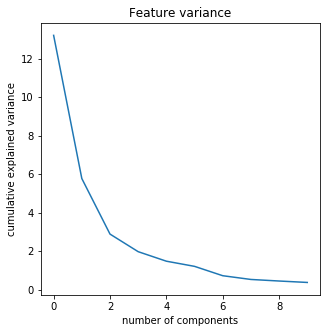

In [11]:
plot_feature_variance(pca_input, filedir=filedir, taskname=taskname)

## Plot top 10 histogram over reduced features

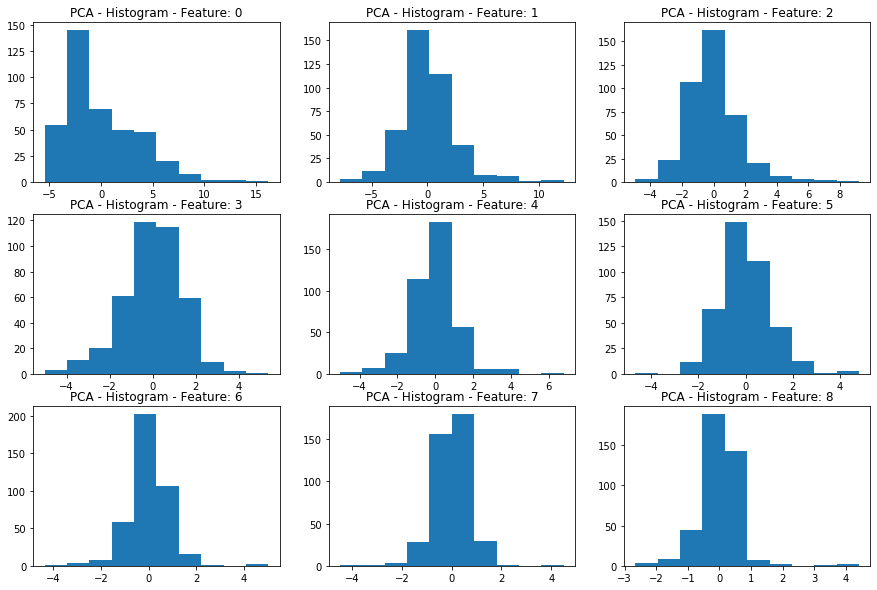

In [12]:
plot_top_features(feature_tot,pca_input, filedir=filedir, taskname=taskname)

# Feature selection
Extract top features above depending on PCA

(400, 30)


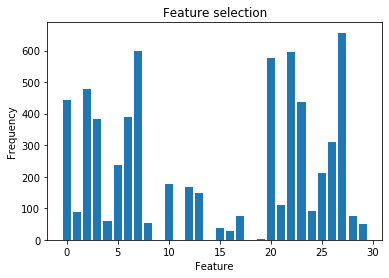

In [13]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, filedir=filedir, taskname=taskname, feature_tot=feature_tot)

## Hyperparameter tuning

In [14]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 447 candidates, totalling 4470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 3032 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 3542 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4092 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 4470 out of 4470 | elapsed: 22.3min finished
/usr/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Save model

In [15]:
save_model(grid, filedir=filedir, taskname=taskname)

Save model into: /home/fredrik/Documents/Learning_Systems/Labs/Project/Models/task5.joblib


## Load model

In [16]:
if not grid: 
    grid = load_model(filedir=filedir, taskname=taskname)

## Get Model info

In [17]:
get_model_info(grid)

Best score: 0.9650000000000001
Best params {'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False), 'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__early_stopping': False, 'clf__hidden_layer_sizes': (100, 20), 'clf__max_iter': 200, 'clf__solver': 'adam'}

                                                                                                                                                                                                                                                                

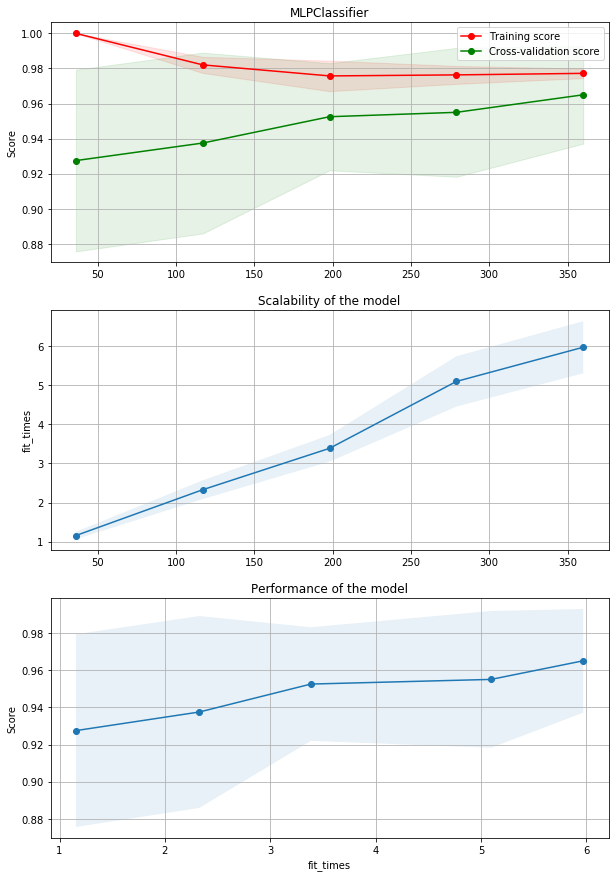

In [18]:
validate_curve(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname, scoring=scoring, k=k)

/usr/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


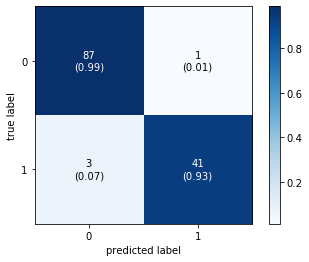

In [19]:
display_confusion_matrix(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname)

# Predict testset

In [20]:
model = predict_model(grid, input_train_fs, target_train, input_test_fs)

/usr/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
